In [6]:
# Setting up by importing all the relevant libraries
import os
import cv2
import numpy as np
import pandas as pd
import sklearn
import PIL
import scipy
from sklearn.externals import joblib
import pytesseract
from PIL import Image
import json
from scipy import misc

In [8]:
print(cv2.__version__)
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)
# print(pytesseract.__version__)
# print(PIL.__version__)
print(scipy.__version__)


3.1.0
1.11.1
0.18.1
0.19.0
0.18.1


In [10]:
import base64
print(base64.__version__)

AttributeError: module 'base64' has no attribute '__version__'

In [298]:
# Setting parameters
dir = r'C:\Users\ankuarora\Desktop\Client\2017_05_CogEx\2017_07_R2Implementation\Sprint 7\4ExtractText\ExtractImageText'
image_file = 'Sample1.png'

In [299]:
# Import the image as a numpy array
img = cv2.imread(os.path.join(dir,image_file),0)

In [300]:
# List of features that need be extracted
feature_list = ['width','height','seq_from_top','seq_from_bottom','width_prv',
                'height_prv','width_nxt','height_nxt']

In [301]:
# Slice the image into sections based on whitespace
features = pd.DataFrame(index=[], columns=feature_list)
features.index.name = "filename"

In [302]:
# Preprocess the image
image = cv2.threshold(img, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# Remove the white borders, if any
p_image = cv2.bitwise_not(image)
coords = np.column_stack(np.where(p_image > 0))
x,y,w,h = cv2.boundingRect(coords)
image_sliced = img[np.max((x-10,0)) : np.min((x+w+10,image.shape[0])),
                     np.max((y-10,0)) : np.min((y+h+10, image.shape[1]))]

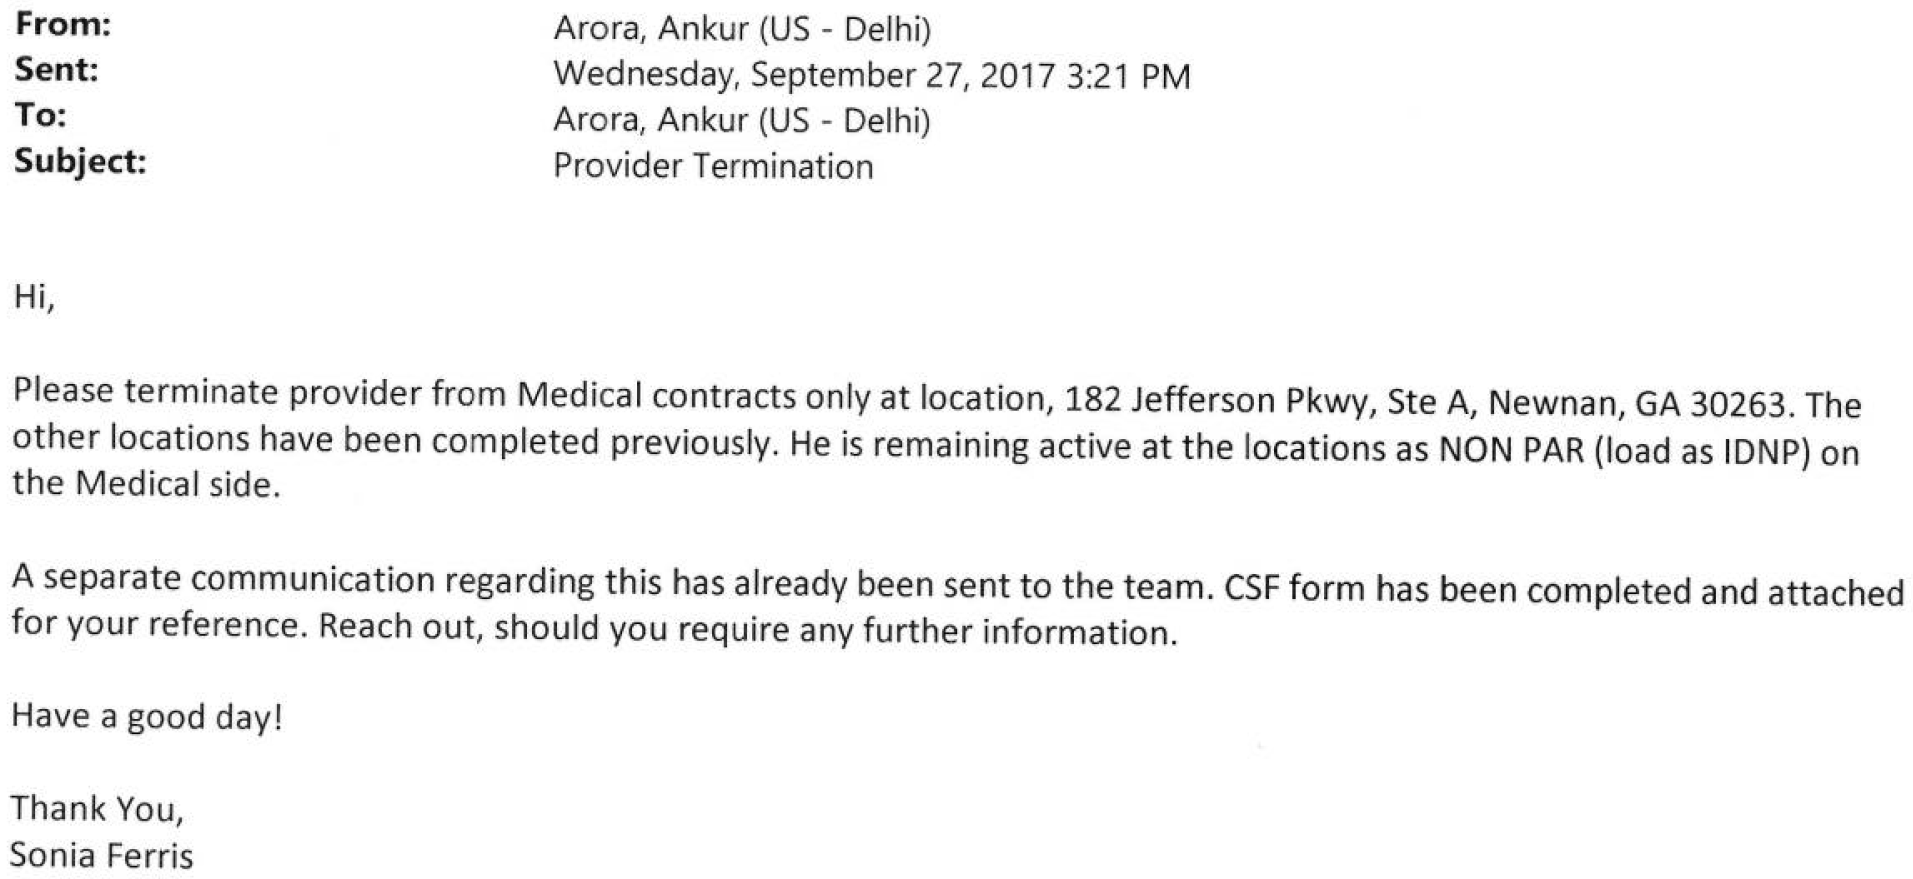

In [303]:
misc.toimage(image_sliced)

In [304]:
# Find lines by horizontally blurring the image and thresholding
blur = cv2.blur(image_sliced, (91,9))
b_mean = np.mean(blur, axis=1)/255
threshold = np.percentile(b_mean, 50)
t = b_mean > threshold
byte_lines = np.where(1-t)
byte_lines = byte_lines[0]
    
# Calculate the median linespace value for defining sections 
linspace = []
for x in range(byte_lines.shape[0]-1):
    if byte_lines[x+1] == byte_lines[x] + 1:
        continue
    linspace.append(byte_lines[x+1]-byte_lines[x]-1)
    linspace_limit = (1.0 * np.median(linspace))

# Add in extra byte lines to cover unwanted linespace
for x in range(byte_lines.shape[0]-1):
    if byte_lines[x+1] == byte_lines[x] + 1:
        continue
    if ((byte_lines[x+1]-byte_lines[x]) <= linspace_limit):
        for i in range(byte_lines[x+1]-byte_lines[x]-1):
            byte_lines = np.append(byte_lines, (byte_lines[x]+i+1))
byte_lines = np.sort(byte_lines)

# Identify text line coordinates (y) based on byte lines
txt_lines_y = []
start_y = byte_lines[0]
for y in range(1, byte_lines.shape[0]-1):
    if byte_lines[y] == byte_lines[y-1] + 1:
        continue
    # identified gap between lines, close previous line and start a new one
    end_y = byte_lines[y-1]
    txt_lines_y.append([start_y, end_y])
    start_y = byte_lines[y]
end_y = byte_lines[-1]
txt_lines_y.append([start_y, end_y])

# Identify text line coordinates (x) based on non blank columns
txt_lines_x = []
for line in txt_lines_y:
    xx = []
    for x in range(image_sliced.shape[1]):
        col = image_sliced[line[0]:line[1], x]
        if np.min(col) < 128:
            xx.append(x)
    txt_lines_x.append([min(xx), max(xx)])

# Slice the document based on the coordinates and perform OCR. 
# Also, create basic features for use in learning.
for i in range(len(txt_lines_x)):
    slc = image_sliced[np.max((txt_lines_y[i][0] - 2,0)) : np.min((txt_lines_y[i][1] + 2,image.shape[0])), 
                       np.max((txt_lines_x[i][0] - 2,0)) : np.min((txt_lines_x[i][1] + 2,image.shape[1]))]
    filename = os.path.splitext(image_file)[0] + '_slice' + str(i+1) + os.path.splitext(image_file)[1]
    misc.imsave(os.path.join(dir, filename), slc)
    features.loc[filename] = [(txt_lines_x[i][1] - txt_lines_x[i][0] + 4)/image_sliced.shape[1],
                              (txt_lines_y[i][1] - txt_lines_y[i][0] + 4)/image_sliced.shape[0],
                              (i+1),
                              (len(txt_lines_y)-i),
                              0 if not i else (txt_lines_x[i-1][1] - txt_lines_x[i-1][0] + 4)/image_sliced.shape[1],
                              0 if not i else (txt_lines_y[i-1][1] - txt_lines_y[i-1][0] + 4)/image_sliced.shape[0],
                              0 if i==len(txt_lines_x)-1 else (txt_lines_x[i+1][1] - txt_lines_x[i+1][0] + 4)/image_sliced.shape[1],
                              0 if i==len(txt_lines_y)-1 else (txt_lines_y[i+1][1] - txt_lines_y[i+1][0] + 4)/image_sliced.shape[0],
                             ]

In [305]:
# Import the model and classify sections
model_classify = joblib.load('section_classifier.pkl')
features['prediction'] = model_classify.predict(features)

In [306]:
features

,width,height,seq_from_top,seq_from_bottom,width_prv,height_prv,width_nxt,height_nxt,prediction
filename,,,,,,,,,
Sample1_slice1.png,0.615264,0.196815,1.0,6.0,0.000000,0.000000,0.015159,0.009101,0
Sample1_slice2.png,0.015159,0.009101,2.0,5.0,0.615264,0.196815,0.967590,0.145620,0
Sample1_slice3.png,0.967590,0.145620,3.0,4.0,0.015159,0.009101,0.990068,0.100114,1
Sample1_slice4.png,0.990068,0.100114,4.0,3.0,0.967590,0.145620,0.140617,0.036405,1
Sample1_slice5.png,0.140617,0.036405,5.0,2.0,0.990068,0.100114,0.096707,0.088737,0
Sample1_slice6.png,0.096707,0.088737,6.0,1.0,0.140617,0.036405,0.000000,0.000000,0


In [290]:
ocr = []
cnt = 0
for key, row in features.iterrows():
    if row['prediction']:
        out = {
                "index": cnt,
                "section": "",
                "attribute": "", 
                "text": pytesseract.image_to_string(Image.open(os.path.join(dir, key))),
                "type": "text"
        }
        cnt = cnt+1
        ocr.append(out)
    os.remove(os.path.join(dir, key))

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\Users\\ankuarora\\Desktop\\Client\\2017_05_CogEx\\2017_07_R2Implementation\\Sprint 7\\4ExtractText\\ExtractImageText\\Sample1_slice1.png'

In [286]:
ocr

[{'attribute': '',
  'index': 0,
  'section': '',
  'text': 'From: Arora, Ankur (US - Delhi)\n\nSent: Wednesday, September 27, 2017 3:21 PM\nTo: Arora, Ankur (US - Delhi)\n\nSubject: Provider Termination',
  'type': 'text'},
 {'attribute': '',
  'index': 1,
  'section': '',
  'text': 'Please terminate provider from Medical contracts only at location, 182 Jefferson Pkwy, Ste A, Newnan, GA 30263. The\n\nother locations have been completed previously. He is remaining active at the locations as NON PAR (load as IDNP) on\nthe Medical side.',
  'type': 'text'},
 {'attribute': '',
  'index': 2,
  'section': '',
  'text': 'A separate communication regarding this has already been sent to the team. CSF form has been completed and attached\nfor your reference. Reach out, should you require any further information.',
  'type': 'text'}]

In [252]:
img_content = {
                "data": ocr,
                "attachment_type": "image", 
                "type": "attachment"
              } 

In [253]:
with open(os.path.join(dir, os.path.splitext(image_file)[0] + ".json"), 'w') as fp:
    json.dump(img_content, fp, indent=4)